In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'breast-ultrasound-images-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F1209633%2F2021025%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240509%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240509T062447Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8318cedf28fc6da5560da6d0d80316ee89534d139e9c0774fe9cbaba91a0dc510e090a5ae1e5d9b67fd6c2706a5092152ca304e21138f5853f206c0b59c3fc041b990ed5e7948cfb9ee657eed84fcbaa26a3719eaf8daee89baa7300c89cac49c9180f6856c26cbd7243653583e57d4e7a2c8591bb47faa2fc6b0639400f7f1f401f71628407f937dad47a3d7c78d8a281a37b9c09bb6fe687ccee2f718147764581c49f83149d4bb95eeb8c807f6252430c2bf4d545b6a11482e66ad11700cb15d86eb9efae19437bca7deca4feea7a91d65b4a6782ba6ad946de0298897a339c4cb6f5cb6903b6d51d813538c50ab7633d087813b2cfa70d03efb67ced7393'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 204421470 bytes downloaded
Downloaded and uncompressed: breast-ultrasound-images-dataset
Data source import complete.


In [ ]:
import numpy as np # linear algebra
import os

DATASET

In [ ]:
BASE_PATH = '/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT'
unique_classes = []
for path in os.listdir(BASE_PATH):
    unique_classes.append(path)
print(unique_classes)

['benign', 'malignant', 'normal']


In [ ]:
class_index = [unique_classes[1], unique_classes[0], unique_classes[2]]
for c in class_index:
    print(c, "-", class_index.index(c))

malignant - 0
benign - 1
normal - 2


LOADING IMAGES AND MASKS PATHS

In [ ]:
images = []
masks = []
labels = []
for folder in os.listdir(BASE_PATH):
    class_path = os.path.join(BASE_PATH, folder)
    for img in os.listdir(class_path):
        if "_mask" not in img:
            img_path = os.path.join(class_path, img)
            msk_path = img_path.replace(".png", "_mask.png")
            # check if mask exist
            if os.path.exists(msk_path):
                images.append(img_path)
                masks.append(msk_path)
                labels.append(folder)

In [ ]:
print(len(images))

780


In [ ]:
images[0]

'/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/benign/benign (265).png'

In [ ]:
input_images_size = 256
channel = 1

DATA LOADING AND PREPROCESSING

In [ ]:
import cv2
import scipy
import scipy.ndimage


def load_image(img_path):
    """ Load single image as Grayscale
    """
    # load image as grayscale
    img = cv2.imread(img_path, 0)
    return img

def padding(img, msk):
    """ Pad images to make them square
    """
    size = np.max(img.shape)

    offset_x = (size-img.shape[0])//2
    offset_y = (size-img.shape[1])//2

    blank_image = np.zeros((size, size))
    blank_mask = np.zeros((size, size))

    blank_image[offset_x:offset_x+img.shape[0],
               offset_y:offset_y+img.shape[1]] = img
    blank_mask[offset_x:offset_x+img.shape[0],
               offset_y:offset_y+img.shape[1]] = msk
    return blank_image, blank_mask

def resize_mask(mask):
    """Resize mask, its different because mask pixel value can change because of resize
    """
    new_size = np.array([input_images_size, input_images_size]) / mask.shape
    mask = scipy.ndimage.interpolation.zoom(mask, new_size)
    return mask

def resize(img):
    """Resize image
    """
    img = cv2.resize(img, (input_images_size, input_images_size))
    return img

def preprocess(img):
    """Image preprocessing
    Normalize image
    """
    img = img/255.0
    return img

def inverse_preprocess(img):
    """Inverse of preprocessing
    """
    img = img*255
    return img

def load_data(img_path, msk_path, label):
    """Load image, mask and repalce mask value with class index
    0 = normal
    1 = benign
    2 = malignant
    """
    img = load_image(img_path)
    msk = load_image(msk_path)
    img, msk = padding(img, msk)
    label_indx = class_index.index(label)
    msk[msk == 255] = 1
    msk = msk.astype("uint8")
    img = resize(img)
    msk = resize_mask(msk)
    new_mask = np.zeros((input_images_size, input_images_size, 2))
    if label_indx != 0:
        new_mask[:, :, label_indx-1] = msk
#     print(np.unique(msk), label, label_indx)
    return img, new_mask

def load_batch(images, masks, labels):
    """Load Batch of data
    """
    batch_x = []
    batch_y = []
    for i, m, l in zip(images, masks, labels):
        img, msk = load_data(i, m, l)
        img = preprocess(img)
        batch_x.append(img)
        batch_y.append(msk)
    return np.array(batch_x), np.array(batch_y)

<ipython-input-9-1e523946cf1c>:34: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  mask = scipy.ndimage.interpolation.zoom(mask, new_size)


0.0 255.0 (256, 256)


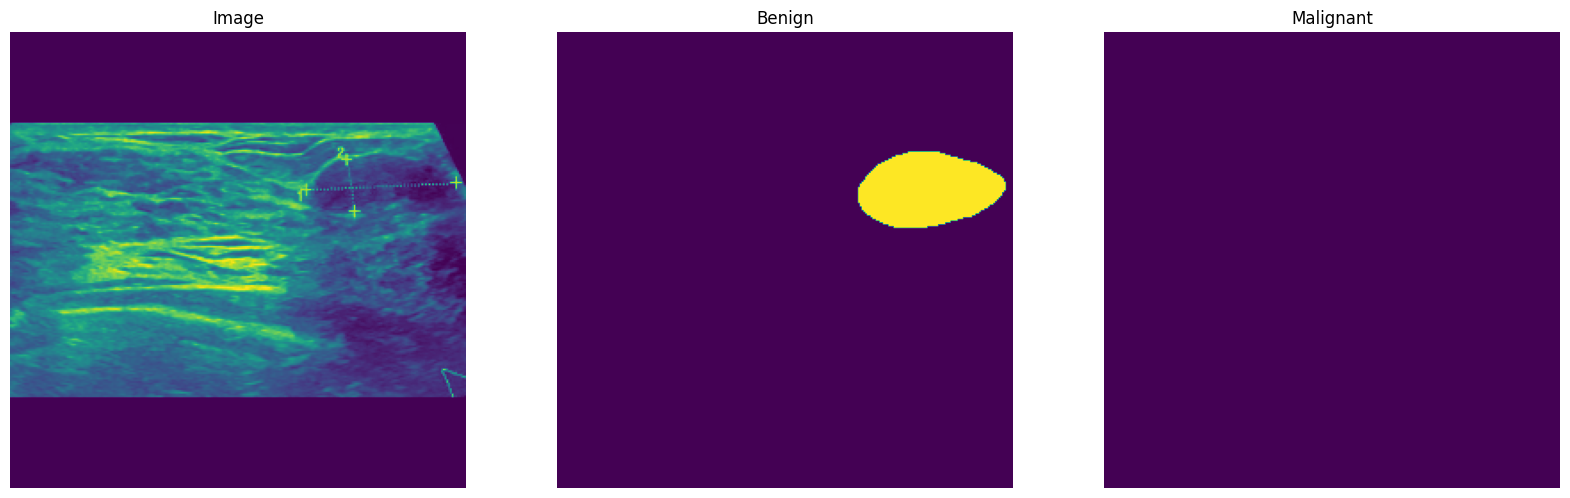

0.0 255.0 (256, 256)


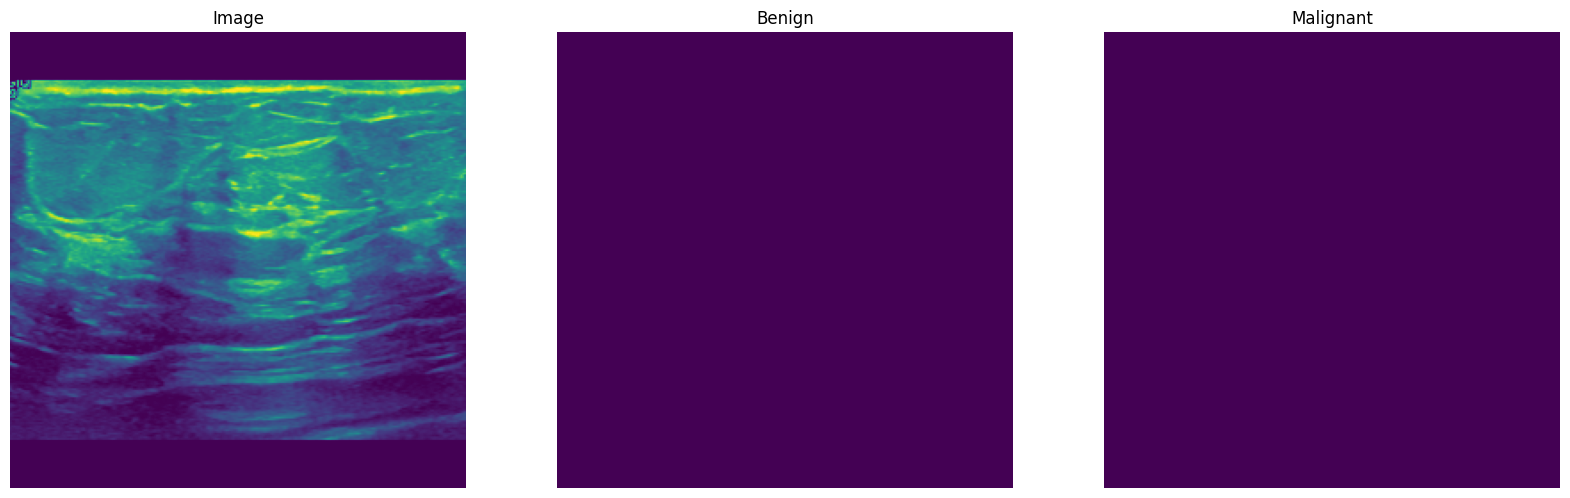

0.0 245.66925811767578 (256, 256)


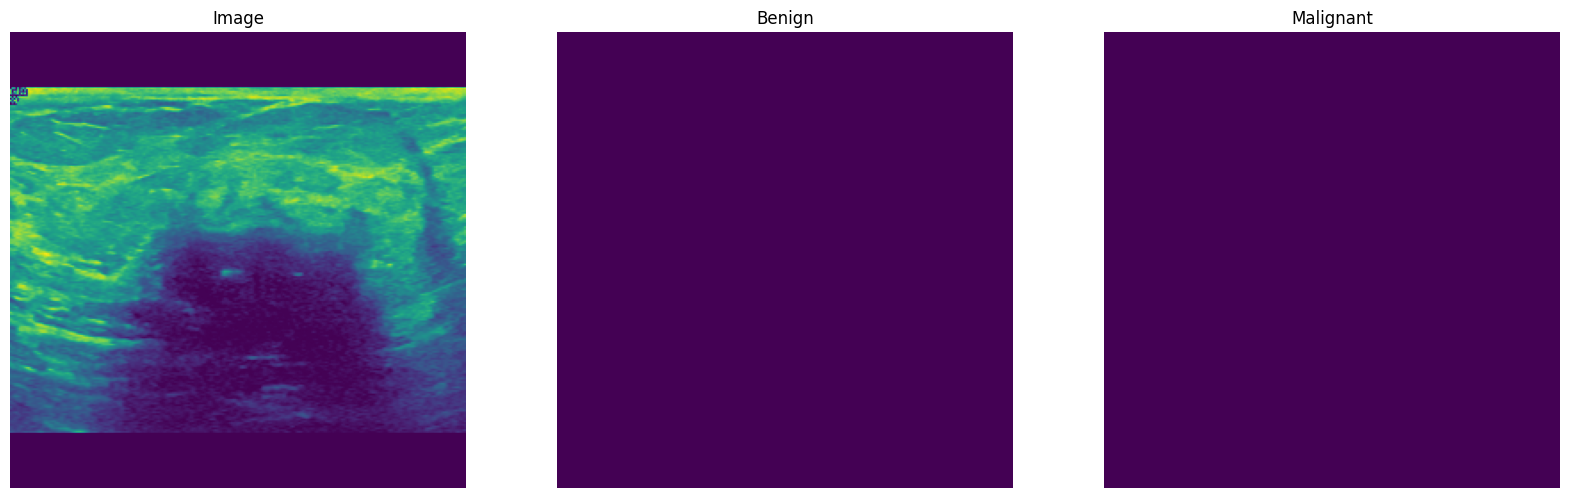

In [ ]:
import matplotlib.pyplot as plt
for i in [0, 500, 600]:
    indx = i
    img, msk = load_data(images[indx], masks[indx], labels[indx])
    print(np.min(img), np.max(img), img.shape)
    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow(img)
    plt.title('Image')
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(msk[:, :, 0])
    plt.title('Benign')
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(msk[:, :, 1])
    plt.title('Malignant')
    plt.show()

In [ ]:
images = np.array(images)
masks = np.array(masks)
labels = np.array(labels)

MODEL

In [ ]:
!pip install segmentation_models

In [ ]:
import segmentation_models as sm
import tensorflow as tf

# Set the framework to 'tf.keras' if it's not already set
sm.set_framework('tf.keras')

# Define input parameters
BACKBONE = 'efficientnetb0'  # EfficientNetB0 backbone
LR = 0.00001
input_images_size = 256  # Assuming a specific input size
channel = 3  # Assuming RGB images

# Load the EfficientNet-based UNet model
model = sm.Unet(BACKBONE, classes=2, activation="sigmoid",
                input_shape=(input_images_size, input_images_size, channel),
                encoder_weights=None)

optim = tf.keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5),
           sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)


TRAINING

In [ ]:
import segmentation_models as sm
import tensorflow as tf
import numpy as np

sm.set_framework('tf.keras')

BACKBONE = 'efficientnetb0'  # Change the backbone to EfficientNetB0
LR = 0.00001
input_images_size = 256  # Assuming a specific input size
channel = 1  # Assuming single-channel images

# Load the EfficientNet-based UNet model
model = sm.Unet(BACKBONE, classes=2, activation="sigmoid",
                input_shape=(input_images_size, input_images_size, channel),
                encoder_weights=None)

optim = tf.keras.optimizers.Adam(LR)

dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = [sm.metrics.IOUScore(threshold=0.5),
           sm.metrics.FScore(threshold=0.5)]

model.compile(optim, total_loss, metrics)

# Assuming you have defined images, masks, and labels appropriately

batch_size = 4
history = {"epoch": []}
for e in range(11):
    print("epoch:", e, end=" > ")
    indexes = list(range(len(images)))
    temp_history = {"loss": [], "IOU": [], "F-Score": []}
    for b in range(0, len(images), batch_size):
        bs = b
        be = bs + batch_size
        batch_index = indexes[bs:be]
        batch_x, batch_y = load_batch(images[batch_index], masks[batch_index], labels[batch_index])
        batch_x = np.expand_dims(batch_x, axis=-1)
        batch_y = np.expand_dims(batch_y, axis=-1)
        batch_y = batch_y.astype("float32")
        loss = model.train_on_batch(batch_x, batch_y)
        temp_history["loss"].append(loss[0])
        temp_history["IOU"].append(loss[1])
        temp_history["F-Score"].append(loss[2])
    print("loss", np.round(np.mean(temp_history["loss"]), 4),
          "IOU", np.round(np.mean(temp_history["IOU"]), 4),
          "F-Score", np.round(np.mean(temp_history["F-Score"]), 4))
    history["epoch"].append(temp_history)

model.save_weights("mammogram_tumor_segmentation")


epoch: 0 > 

<ipython-input-9-1e523946cf1c>:34: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  mask = scipy.ndimage.interpolation.zoom(mask, new_size)


loss 1.0689 IOU 0.0179 F-Score 0.0331
epoch: 1 > loss 1.0306 IOU 0.0242 F-Score 0.0436
epoch: 2 > loss 1.0083 IOU 0.0374 F-Score 0.0635
epoch: 3 > loss 0.9926 IOU 0.0576 F-Score 0.0917
epoch: 4 > loss 0.9798 IOU 0.0753 F-Score 0.1143
epoch: 5 > loss 0.9686 IOU 0.0932 F-Score 0.1352
epoch: 6 > loss 0.9601 IOU 0.101 F-Score 0.1429
epoch: 7 > loss 0.9509 IOU 0.1143 F-Score 0.1577
epoch: 8 > loss 0.9415 IOU 0.1256 F-Score 0.1678
epoch: 9 > loss 0.9341 IOU 0.1338 F-Score 0.1753
epoch: 10 > loss 0.9266 IOU 0.1382 F-Score 0.1795


TESTING

<ipython-input-9-1e523946cf1c>:34: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  mask = scipy.ndimage.interpolation.zoom(mask, new_size)


0.0 255.0 (256, 256)
(256, 256)
1/1 [==============================] - 2s 2s/step


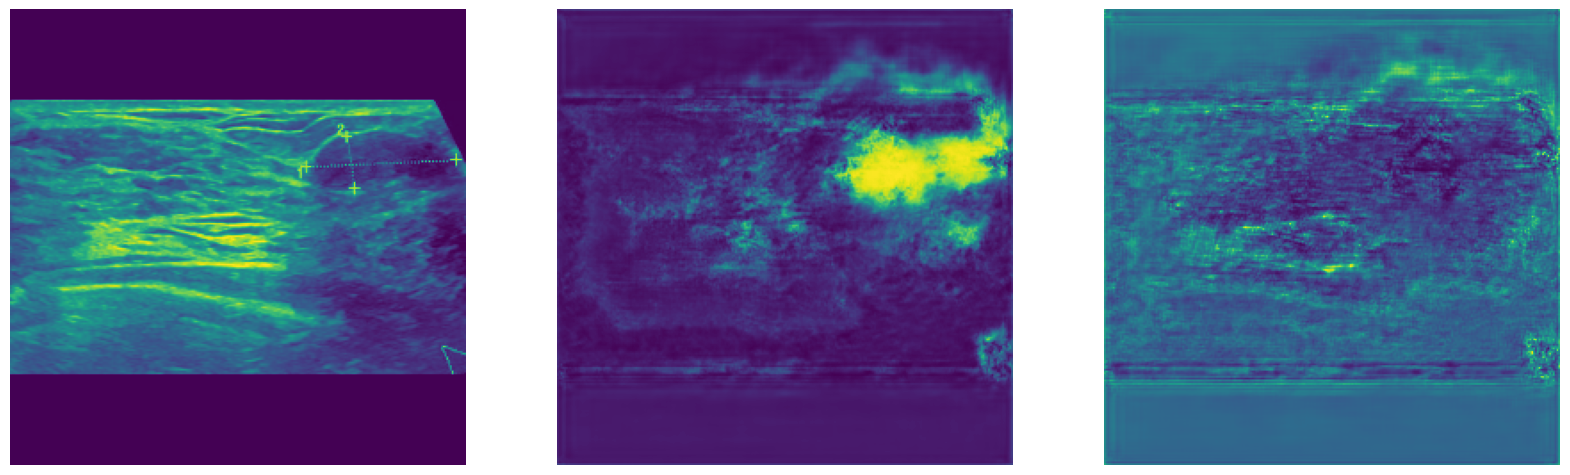

0.0 255.0 (256, 256)
(256, 256)
1/1 [==============================] - 0s 311ms/step


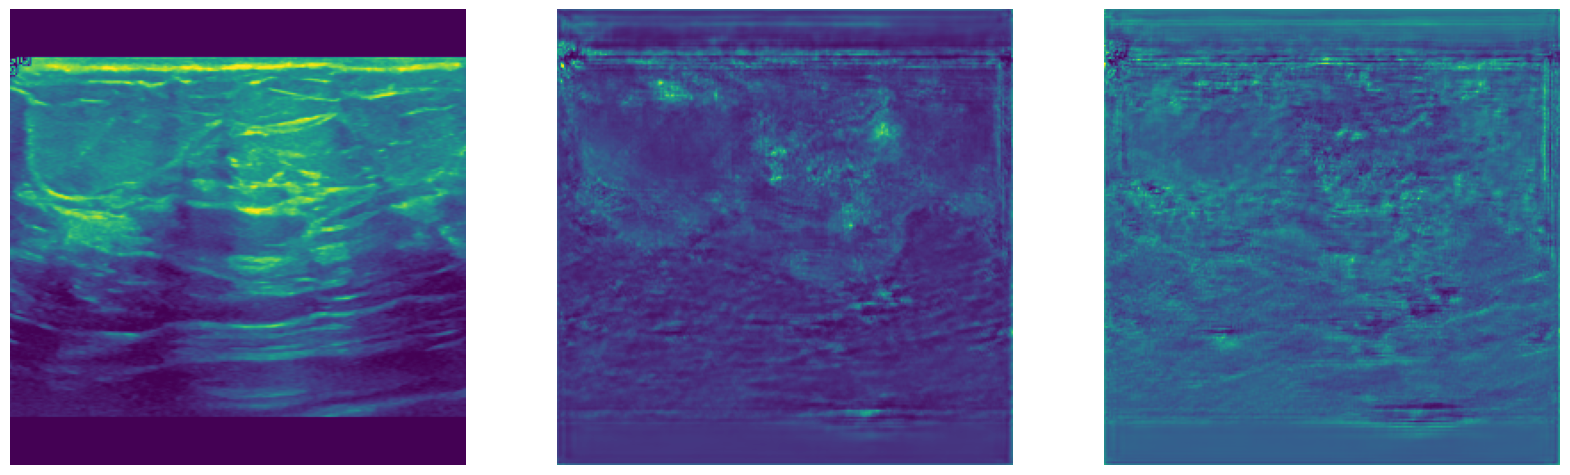

0.0 245.66925811767578 (256, 256)
(256, 256)
1/1 [==============================] - 0s 277ms/step


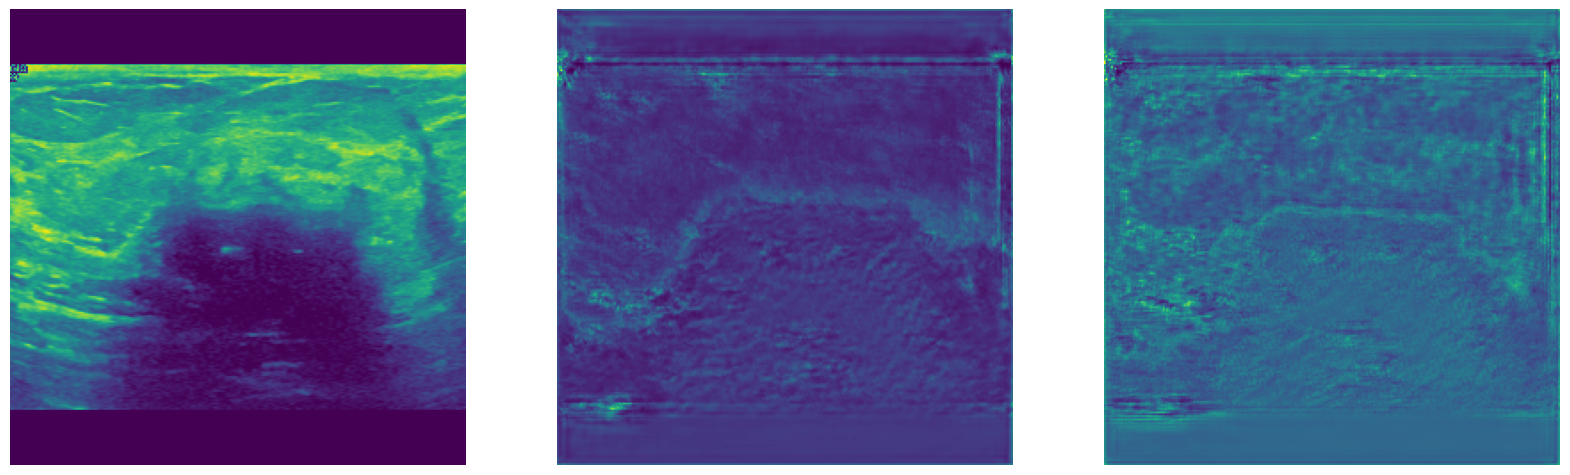

In [ ]:
import matplotlib.pyplot as plt
for i in [0, 500, 600]:
    indx = i
    img, msk = load_data(images[indx], masks[indx], labels[indx])
    print(np.min(img), np.max(img), img.shape)
    print(img.shape)

    img2 = preprocess(img)
    pred = model.predict(np.array([img2]))
    pred = pred[0]

    plt.figure(figsize=(20, 20))
    plt.subplot(1, 3, 1)
    plt.axis("off")
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.axis("off")
    plt.imshow(pred[:, :, 0])
    plt.subplot(1, 3, 3)
    plt.axis("off")
    plt.imshow(pred[:, :, 1])
    plt.show()

In [6]:
import numpy as np

def extract_labels(predicted_masks, threshold=0.5):
    # Example extract_labels function for binary classification
    binary_masks = (predicted_masks > threshold).astype(np.uint8)
    predicted_labels = np.zeros(binary_masks.shape[:-1], dtype=np.uint8)
    predicted_labels[binary_masks[..., 1] == 1] = 1  # Assuming class 1 for positive prediction
    return predicted_labels

# Example: Assuming you have validation labels stored in validation_labels
validation_labels = np.array([0])  # Example validation labels
# Example: Assuming you have obtained predicted_masks from your model
predicted_masks = np.random.rand(5, 128, 128, 2)  # Example predicted masks

# Calculate predicted labels using extract_labels
predicted_labels = extract_labels(predicted_masks)

# Flatten the predicted_labels to match the shape of validation_labels
predicted_labels_flat = predicted_labels.flatten()

# Calculate accuracy
accuracy = np.mean(validation_labels == predicted_labels_flat)

print("Accuracy:", accuracy)


Accuracy: 0.5007568359375
